In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE
#from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('CODids.csv',encoding = 'unicode_escape')
df2= pd.read_csv('bandgaps.csv',encoding = 'unicode_escape')
df['bandgaps']=df2['bgs']
df=df.head(1000)

In [3]:
"""
featurelist= ['_chemical_formula_sum', "_chemical_formula_weight",  "_space_group_IT_number", 
"_symmetry_cell_setting",  "_symmetry_space_group_name_H-M",  "_cell_angle_alpha",  "_cell_angle_beta", 
"_cell_angle_gamma",  "_cell_formula_units_Z",  "_cell_length_a",  "_cell_length_b",  "_cell_length_c", 
"_cell_measurement_reflns_used",  "_cell_measurement_temperature",  "_cell_measurement_theta_max",  
"_cell_measurement_theta_min",  "_cell_volume",  "_diffrn_radiation_wavelength",  
"_diffrn_reflns_av_R_equivalents",  "_diffrn_reflns_av_sigmaI/netI",  "_diffrn_reflns_limit_h_max",  
"_diffrn_reflns_limit_h_min",  "_diffrn_reflns_limit_k_max",  "_diffrn_reflns_limit_k_min",  
"_diffrn_reflns_limit_l_max",  "_diffrn_reflns_limit_l_min",  "_diffrn_reflns_number",  
"_diffrn_reflns_theta_full",  "_diffrn_reflns_theta_max",  "_diffrn_reflns_theta_min",  
"_exptl_absorpt_coefficient_mu",  "_exptl_absorpt_correction_T_max",  "_exptl_absorpt_correction_T_min"]

"""   
# choosing features 
featurelist = ['_chemical_formula_sum','_chemical_formula_weight',"_symmetry_space_group_name_H-M"]
for x in featurelist:
    stringlist=['_chemical_formula_sum', "_symmetry_space_group_name_H-M"]
    if x in stringlist:
        df[x]= ''
    else:
        df[x]=-100.1

In [4]:
# get info 
for x in df['ids']:
    id= str(x)
    index=df.loc[df['ids'] == x].index[0]
    url=requests.get('http://www.crystallography.net/cod/'+id+'.cif')
    htmltext = url.text
    for y in featurelist:
        matched_lines = [line for line in htmltext.split('\n') if y in line]
        if len(matched_lines)>0:
            if y=="_chemical_formula_sum" or y=="_symmetry_space_group_name_H-M":
                matched_lines= matched_lines[0].split("'")
                df.set_value(index, y, matched_lines[1])
            else:
                matched_lines= matched_lines[0].split(" ")
                k=matched_lines[-1]
                if '(' in k:
                    k= k.split('(')[0]
                if y!="_symmetry_cell_setting":
                    try:
                        k=float(k)
                    except ValueError:
                        k=-100
                df.set_value(index, y, k)

/Users/michellevoong/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/Users/michellevoong/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


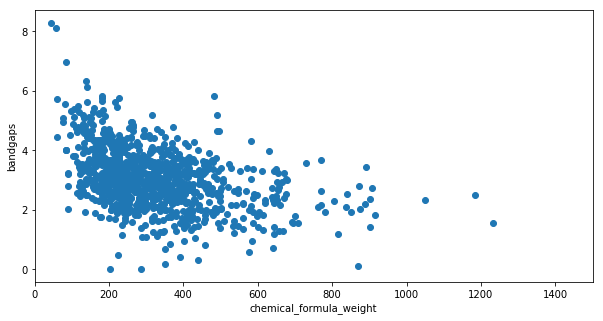

In [6]:
# plot chemical formula weight vs. bandgaps 
plt.figure(figsize=(10, 5))
plt.scatter(df['_chemical_formula_weight'],df['bandgaps'])
plt.xlim(0, 1500)
plt.ylabel('bandgaps')
plt.xlabel('chemical_formula_weight')
plt.show()

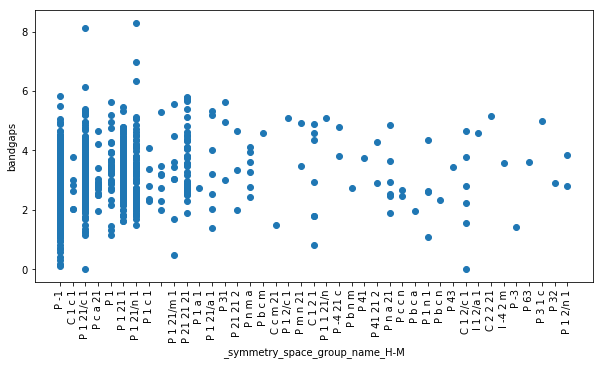

In [7]:
# plot symmetry space group name vs. bandgaps 
plt.figure(figsize=(10, 5))
plt.scatter(df['_symmetry_space_group_name_H-M'],df['bandgaps'])
plt.ylabel('bandgaps')
plt.xlabel('_symmetry_space_group_name_H-M')
plt.xticks(rotation=90)
plt.show()

In [8]:
def corr_calc(x, y):
    from scipy.stats import pearsonr, spearmanr 
    covariance = np.cov(x,y)
    pcorr, _ = pearsonr(x,y)
    scorr, _ = spearmanr(x,y)
    print('Covariance: ')
    print(covariance)
    print('Pearsons Correlation: ', pcorr)
    print('Spearmans Correlation: ', scorr)

corr_calc(df['_chemical_formula_weight'],df['bandgaps'])

Covariance: 
[[ 3.30836132e+04 -6.98123875e+01]
 [-6.98123875e+01  1.02254908e+00]]
Pearsons Correlation:  -0.379563061884622
Spearmans Correlation:  -0.4144775942200489


In [7]:
from dscribe.descriptors import SineMatrix
# Setting up the sine matrix descriptor
sm = SineMatrix(
    n_atoms_max=6,
    permutation="sorted_l2",
    sparse=False,
    flatten=True
)

In [11]:
from ase.build import bulk, molecule
# NaCl crystal created as an ASE.Atoms
nacl = bulk("NaCl", "rocksalt", a=5.64)

# Create output for the system
nacl_sine = sm.create(nacl)

# Create output for multiple system
al = bulk("Al", "fcc", a=4.046)
fe = bulk("Fe", "bcc", a=2.856)
samples = [nacl, al, fe]
sine_matrices = sm.create(samples)            # Serial
sine_matrices = sm.create(samples, n_jobs=2)  # Parallel


In [23]:
#test = molecule("C19H17NO5",a=5.64)
from ase.collections import g2

molecules = g2.names

for x in df['ids']:
    id= str(x)
    index=df.loc[df['ids'] == x].index[0]
    url=requests.get('http://www.crystallography.net/cod/'+id+'.cif')
    htmltext = url.text
    for y in featurelist:
        matched_lines = [line for line in htmltext.split('\n') if y in line]
        if len(matched_lines)>0:
            if y=="_chemical_formula_sum" or y=="_symmetry_space_group_name_H-M":
                matched_lines= matched_lines[0].split("'")
                df.set_value(index, y, matched_lines[1])
            else:
                matched_lines= matched_lines[0].split(" ")
                k=matched_lines[-1]
                if '(' in k:
                    k= k.split('(')[0]
                if y!="_symmetry_cell_setting":
                    try:
                        k=float(k)
                    except ValueError:
                        k=-100
                df.set_value(index, y, k)


162


In [29]:
df['_chemical_formula_sum']

for item in df['_chemical_formula_sum']:
    

0      C15 H28 Mo N4 O2 P2
1            C11 H8 Cl4 O3
2             C19 H17 N O5
3           C11 H10 Cl2 N2
4             C12 H13 N O2
              ...         
995     C36 H80 Mg2 N4 Si4
996          C18 H18 B N O
997          C5 H10 Br2 O2
998           C13 H11 N O3
999           C7 H10 N2 O2
Name: _chemical_formula_sum, Length: 1000, dtype: object

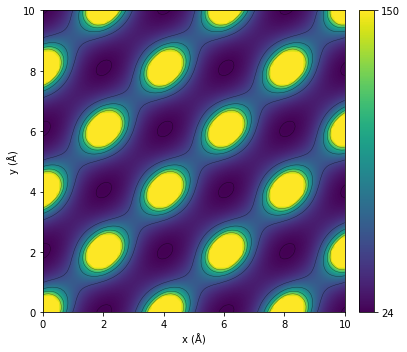

In [14]:
import numpy as np
from ase import Atoms
import matplotlib.pyplot as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

# FCC aluminum crystal
system = bulk("Al", "fcc", cubic=False)

# Calculate the sine matrix entries for a 2D slice at z=0
sm = SineMatrix(
    n_atoms_max=2,
    permutation="none",
    sparse=False,
    flatten=False
)
n = 100
d = 10
grid = np.zeros((n, n))
values = np.linspace(0, d, n)
for ix, x in enumerate(values):
    for iy, y in enumerate(values):
        i_atom = Atoms(["Al"], positions=[[x, y, 0]])
        i_sys = system.copy()+i_atom
        i_sm = sm.create(i_sys)
        i_sm = i_sm[0, 1]
        grid[ix, iy] = i_sm

# Plot the resulting sine matrix values
maxval = 150
fig, ax = mpl.subplots(figsize=(6, 5))
np.clip(grid, a_min=None, a_max=maxval, out=grid)
c1 = ax.contourf(values, values, grid, levels=500)
ax.contour(values, values, grid, levels=5, colors="k", linewidths=0.5, alpha=0.5)
the_divider = make_axes_locatable(ax)
color_axis = the_divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(c1, cax=color_axis, ticks=[grid.min(), grid.max()])
ax.axis('equal')
ax.set_ylabel("y (Å)")
ax.set_xlabel("x (Å)")
mpl.tight_layout()
mpl.show()

In [15]:
mpl.show()